In [1]:
import orbax.checkpoint as ocp
import os
from ml_collections import ConfigDict
from pathlib import Path
from utils import prepare_test_dataset
from dataset_utils import get_dataset
from jax import random
from models.utils import sample_gaussian

import models.ClassifierGFZ as ClassifierGFZ
import models.ClassifierDFZ as ClassifierDFZ

checkpoint_path = "dfz-2-epochs-first-try-1"
path = os.path.join(Path.cwd(), Path(f"checkpoints"), Path(checkpoint_path))
checkpoint = ocp.PyTreeCheckpointer().restore(path, item=None)

config = ConfigDict(checkpoint["config"])
dataset_config = ConfigDict(checkpoint["dataset_config"])

if config.model_name == "GFZ":
    classifier = ClassifierGFZ
elif config.model_name == "DFZ":
    classifier = ClassifierDFZ
else:
    raise NotImplementedError(config.model_name)

_, test_ds = get_dataset(config.dataset)
test_images, test_labels = prepare_test_dataset(
    test_ds, dataset_config
    )

trained_params = checkpoint["params"]

log_likelyhood_fn = classifier.log_likelyhood_A

test_key = random.PRNGKey(config.seed)

test_key, model, _ = classifier.create_and_init(
    test_key, config, dataset_config
)

c:\Users\Manal\Desktop\3A\PGM\adversarial-attacks-on-generative-classifiers\.venv\lib\site-packages\orbax\checkpoint\type_handlers.py:1346: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [2]:
from flax import linen as nn
import jax
from jax import jacrev
import numpy as np
from functools import partial
from jax.scipy.special import logsumexp
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import optax
from scipy.optimize import minimize

def init_data(test_key, n_samples=10):
    idx = np.random.choice(range(len(test_images)), n_samples, replace=False)

    all_xs = test_images[idx]
    true_ys = test_labels[idx]
    true_labels = np.argmax(true_ys, axis=1)

    K = model.K
    batch_size = n_samples
    test_key, epsilons = sample_gaussian(test_key, (batch_size, model.n_classes * K, model.d_latent))
    epsilons = epsilons[:n_samples*model.n_classes]
    all_ys = nn.one_hot(jnp.repeat(jnp.arange(model.n_classes), K), model.n_classes, dtype=jnp.float32)
    
    return all_xs, true_labels, epsilons, all_ys, K, test_key

def get_model_output(x, epsilon, y, K):
    z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz = jax.vmap(
            partial(model.apply, {'params': trained_params}, train=False),
            in_axes=(None, 0, 0)
        )(x, y, epsilon)

    ll = log_likelyhood_fn(
            z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz
        ).reshape(model.n_classes, K)
    ll = logsumexp(ll, axis=1) - np.log(K)
    return ll

def get_model_jacobian(x, epsilon, y, K):
    return jacrev(get_model_output, argnums=0)(x, epsilon, y, K)

def map_label_to_name(y):
    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    return labels[y]

In [3]:
class Constrained_BFGS_B():
    def __init__(self, f, grad, x0, bounds, maxiter=1000, eps=1e-8):
        self.f = f
        self.grad = grad
        self.x0 = x0
        self.bounds = bounds
        self.maxiter = maxiter
        self.eps = eps

    def line_search(self, x, direction, alpha = 0.4, beta=0.8, max_iter=1000):
        step_size = 1
        i = 0
        while i < max_iter:
            if self.f(x + step_size  * direction) <= self.f(x) + step_size * alpha * direction.dot(self.grad(x)):
                break
            step_size  *= beta
            i += 1
            
        return step_size
    
    def determine_active_set(self, x, bounds):
        active_set = np.ones_like(x, dtype=bool)

        for i, (lower_bound, upper_bound) in enumerate(bounds):
            if lower_bound is not None and x[i] <= lower_bound:
                active_set[i] = False  # Variable is at the lower bound
            elif upper_bound is not None and x[i] >= upper_bound:
                active_set[i] = False  # Variable is at the upper bound

        return active_set
    
    def update_inverse_hessian_bfgs_b(self, Bk, sk, yk, active_set):
        sk_active = sk[active_set]
        yk_active = yk[active_set]

        if not any(active_set):
            return Bk

        rho = 1 / np.dot(yk_active, sk_active)
        term1 = np.eye(len(sk_active)) - np.outer(sk_active, yk_active) * rho
        term2 = np.eye(len(sk_active)) - np.outer(yk_active, sk_active) * rho
        Bk1_active = np.dot(term1, np.dot(Bk, term2)) + np.outer(rho * sk_active, sk_active)
        Bk1 = Bk.copy()
        Bk1[np.ix_(active_set, active_set)] = Bk1_active

        return Bk1

    def optimize(self):
        x = self.x0
        B = np.eye(len(x))
        for i in range(self.maxiter):
            g = self.grad(x)
            if np.linalg.norm(g) < self.eps:
                break
            direction = -B.dot(g)
            step_size = self.line_search(x, direction)
            x_new = x + step_size * direction
            s = x_new - x
            y = self.grad(x_new) - g
            active_set = self.determine_active_set(x_new, self.bounds)
            B = self.update_inverse_hessian_bfgs_b(B, s, y, active_set)
            x = x_new
            print(self.f(x))

        return x


In [4]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
from jaxopt import ScipyBoundedMinimize

class L_BGFS_Attack():
    def __init__(self, model, max_iter=100, learning_rate=1, p=2):
        self.model = model
        self.n_classes = model.n_classes
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        assert p > 1 
        self.p = p
        if self.p == np.inf:
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)

    def qnorm(self, x):
        return jnp.linalg.norm(x.flatten(), self.q)

    def get_label(self, x):
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return jnp.argmax(val)

    def get_likelihoods(self, x):
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return val

    def get_gradients(self, x):
        J = get_model_jacobian(x, self.epsilon, self.y, self.K)
        return J.flatten()

    def loss(self, val, label):
        label_one_hot_encoding = jax.nn.one_hot(jnp.array([label]), self.n_classes)
        return optax.softmax_cross_entropy(val, label_one_hot_encoding)
    
    def project_to_bounds(self, x):
        bounds_min = jnp.zeros_like(x)
        bounds_max = jnp.ones_like(x)
        return jnp.clip(x, bounds_min, bounds_max)

    def get_perturbation(self, x, epsilon, all_ys, K, c = 1):
        corrupted_x = x.copy()
        self.y = all_ys
        self.epsilon = epsilon
        self.K = K
        self.c = c
        true_label = self.get_label(x)
        max_perturbation_norm = -1
        best_label = true_label
        best_corrupted_x = x

        # Line search for c
        for label in range(self.n_classes):
            if label != true_label:
                def get_problem(r):
                    corrupted_x = x + r
                    val = self.get_likelihoods(corrupted_x)
                    return jnp.sum(self.qnorm(r) + self.loss(val, label))

                r_init = jnp.zeros_like(x)
                lbfgsb = ScipyBoundedMinimize(fun=get_problem, method="l-bfgs-b")
                lower_bounds = jnp.zeros_like(r_init)
                upper_bounds = jnp.ones_like(r_init)
                bounds = (lower_bounds, upper_bounds)
                r = lbfgsb.run(r_init, bounds=bounds).params
                corrupted_x = x + r

                # i = 0
                # optimizer = optax.adam(learning_rate=self.learning_rate)
                # state = optimizer.init(jax.device_put(r.flatten()))
                # while i < self.max_iter:
                    # grad = jax.grad(get_problem)(jax.device_put(r.flatten()))
                    # updates, state = optimizer.update(grad, state)
                    # r = optax.apply_updates(jax.device_put(r.flatten()), updates).reshape(corrupted_x.shape)
                    # corrupted_x = self.project_to_bounds(corrupted_x + r, bounds)


                    # if self.get_label(corrupted_x) == label:
                    #     break
                    # else:
                    #     i += 1

                # check if the attack was successful
                new_label = self.get_label(corrupted_x)
                if new_label != label:
                    print("Warning: did not find a perturbation")
                    perturbation_norm = -1
                else:
                    perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
                    print(perturbation_norm)
                # Choose minimal perturbation
                if max_perturbation_norm == -1 and perturbation_norm != -1:
                    max_perturbation_norm = perturbation_norm
                    best_label = new_label
                    best_corrupted_x = corrupted_x
                else : 
                    if perturbation_norm != -1 and perturbation_norm < max_perturbation_norm:
                        max_perturbation_norm = perturbation_norm
                        best_label = new_label
                        best_corrupted_x = corrupted_x

        return best_corrupted_x, best_label, max_perturbation_norm



In [5]:
def get_average_performance(corruption_model, all_xs, epsilons, all_ys, K):
    perturbation_norms = []
    n_samples = len(all_xs)
    for i in tqdm(range(n_samples)):
        x = all_xs[i]
        epsilon = epsilons[i]
        _, _, perturbation_norm = corruption_model.get_perturbation(x, epsilon, all_ys, K)
        perturbation_norms.append(perturbation_norm)
    return np.array(perturbation_norms)

In [6]:
#Testing optimization algorithm
def f(x):
    return x**2

def grad(x):
    return 2*x
f = f
g = grad
bounds = [(0, 1)] * 1
i = 0
corrupted_x = np.array([1])
print(f(corrupted_x))
BFGS = Constrained_BFGS_B(f, g, corrupted_x, bounds)
r = BFGS.optimize()
print(f(r))

[1]
[0.000576]
[3.31776e-07]
[1.17549435e-38]
[1.17549435e-38]


In [7]:
n_samples = 10
all_xs, true_labels, epsilons, all_ys, K, test_key = init_data(test_key, n_samples=n_samples)

corruption_model = L_BGFS_Attack(model)

perturbation_norms_BFGS = get_average_performance(corruption_model, all_xs, epsilons, all_ys, K)
perturbation_norms_successful_BFGS = perturbation_norms_BFGS[perturbation_norms_BFGS != -1]
n_successful_BFGS = len(perturbation_norms_successful_BFGS)
n_successful_BFGS
print(f'Average perturbation norm of L_BGFS Attack model (on {n_successful_BFGS} successful samples): {np.mean(perturbation_norms_successful_BFGS):>.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:54<08:06, 54.06s/it]

 20%|██        | 2/10 [01:52<07:33, 56.70s/it]

 30%|███       | 3/10 [02:43<06:19, 54.19s/it]

 40%|████      | 4/10 [03:34<05:18, 53.00s/it]

 50%|█████     | 5/10 [04:25<04:19, 51.93s/it]

 60%|██████    | 6/10 [05:15<03:25, 51.38s/it]

 70%|███████   | 7/10 [06:05<02:32, 50.97s/it]

 80%|████████  | 8/10 [06:56<01:41, 50.88s/it]

 90%|█████████ | 9/10 [07:46<00:50, 50.79s/it]

100%|██████████| 10/10 [08:39<00:00, 51.96s/it]

Average perturbation norm of L_BGFS Attack model (on 0 successful samples): nan



c:\Users\Manal\Desktop\3A\PGM\adversarial-attacks-on-generative-classifiers\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Manal\Desktop\3A\PGM\adversarial-attacks-on-generative-classifiers\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
# Wagner and carlini attack
import numpy as np
import jax
import jax.numpy as jnp
import optax

class WG_Attack():
    def __init__(self, model, max_iter=10, learning_rate=0.1, c = 1, p=2):
        self.model = model
        self.n_classes = model.n_classes
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.c = c
        assert p > 1 
        self.p = p
        if self.p == np.inf:
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)

    def qnorm(self, x):
        return jnp.linalg.norm(x.flatten(), self.q)

    def get_label(self, x):
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return jnp.argmax(val)

    def get_likelihoods(self, x):
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return val

    def get_gradients(self, x):
        J = get_model_jacobian(x, self.epsilon, self.y, self.K)
        return J

    def loss(self, val, label):
        label_one_hot_encoding = jax.nn.one_hot(jnp.array([label]), self.n_classes)
        return optax.softmax_cross_entropy(val, label_one_hot_encoding)
    
    def f(self, x, target_label, k = 0):
        val = self.get_likelihoods(x)
        max_logit = jnp.max(val[jnp.arange(self.n_classes) != target_label])
        logit_diff = jnp.maximum(max_logit - val[target_label], - k)
        return logit_diff
    
    def get_objective(self, w, x, target_label, k = 0):
        norm = self.qnorm(1/2 * jnp.tanh(w) + 1/2 - x)
        penalty = self.c * self.f(1/2 * jnp.tanh(w) + 1/2, target_label, k = k)
        return norm + penalty
    
    def get_obj_grad(self, w, x, target_label):
        corrupted_x = 1/2 * (jnp.tanh(w) + 1)
        norm_grad = (1 - jnp.tanh(w)**2) * (corrupted_x - x)

        val = self.get_likelihoods(corrupted_x)
        grad_model = self.get_gradients(corrupted_x)
        max_label = jnp.argmax(val[jnp.arange(self.n_classes) != target_label])
        max_logit = val[max_label]
        logit_diff = max_logit - val[target_label]
        if logit_diff <= 0:
            penalty_grad = 0
        else:
            penalty_grad = grad_model[max_label] - grad_model[target_label]
        
        return jnp.sum(norm_grad + self.c * penalty_grad)

    def get_perturbation(self, x, epsilon, all_ys, K):
        self.y = all_ys
        self.epsilon = epsilon
        self.K = K
        x =jax.device_put(x)
        true_label = self.get_label(x)
        max_perturbation_norm = -1
        best_label = true_label
        best_corrupted_x = x
        for label in range(self.n_classes): # to do : optimize this loop
            if label != true_label:
                # use adam optimizer to find minimum of the problem
                w = jnp.zeros_like(x)
                optimizer = optax.adam(learning_rate=self.learning_rate)
                state = optimizer.init(jax.device_put(w))
                for i in range(self.max_iter):
                    corrupted_x = x.copy()                   

                    grad = self.get_obj_grad(w, x, label)
                    # grad = jax.grad(self.get_objective)(w, x, label)
                    # print("grad norm : ", np.linalg.norm(grad))

                    updates, state = optimizer.update(grad, state)
                    w = optax.apply_updates(jax.device_put(w), updates)
                    # w = w - self.learning_rate * grad
                    corrupted_x = 1/2 * (jnp.tanh(w) + 1)
                    print(corrupted_x)
                    plt.imshow(corrupted_x.reshape(28, 28), cmap="gray")
                    if self.get_label(corrupted_x) == label:
                        break
                    
                # check if the attack was successful
                new_label = self.get_label(corrupted_x)
                if new_label != label:
                    print("Warning: did not find a perturbation")
                    perturbation_norm = -1
                else:
                    perturbation_norm = jnp.linalg.norm(corrupted_x - x)/jnp.linalg.norm(x)
                # Choose minimal perturbation
                if max_perturbation_norm == -1 and perturbation_norm != -1:
                    max_perturbation_norm = perturbation_norm
                    best_label = new_label
                    best_corrupted_x = corrupted_x
                else : 
                    if perturbation_norm != -1 and perturbation_norm < max_perturbation_norm:
                        max_perturbation_norm = perturbation_norm
                        best_label = new_label
                        best_corrupted_x = corrupted_x

        return best_corrupted_x, best_label, max_perturbation_norm

In [9]:
# Wagner and carlini attack
import numpy as np
import jax
import jax.numpy as jnp
import optax

class untargeted_WG_Attack():
    def __init__(self, model, max_iter=10, learning_rate=0.1, c = 1, p=2):
        self.model = model
        self.n_classes = model.n_classes
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.c = c
        assert p > 1 
        self.p = p
        if self.p == np.inf:
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)

    def qnorm(self, x):
        return jnp.linalg.norm(x.flatten(), self.q)

    def get_label(self, x):
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return jnp.argmax(val)

    def get_likelihoods(self, x):
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return val

    def get_gradients(self, x):
        J = get_model_jacobian(x, self.epsilon, self.y, self.K)
        return J

    def loss(self, val, label):
        label_one_hot_encoding = jax.nn.one_hot(jnp.array([label]), self.n_classes)
        return optax.softmax_cross_entropy(val, label_one_hot_encoding)
    
    def f(self, x, target_label, k = 0):
        val = self.get_likelihoods(x)
        max_logit = jnp.max(val[jnp.arange(self.n_classes) != target_label])
        logit_diff = jnp.maximum(max_logit - val[target_label], - k)
        return logit_diff
    
    def get_objective(self, w, x, target_label, k = 0):
        norm = self.qnorm(1/2 * jnp.tanh(w) + 1/2 - x)
        penalty = self.c * self.f(1/2 * jnp.tanh(w) + 1/2, target_label, k = k)
        return norm + penalty
    
    def get_obj_grad(self, w, x):
        corrupted_x = x + w
        # corrupted_x = 1/2 * (jnp.tanh(w) + 1)
        norm_grad = 2 * (corrupted_x - x)
        # norm_grad = (1 - jnp.tanh(w)**2) * (corrupted_x - x)

        val = self.get_likelihoods(corrupted_x)
        grad_model = self.get_gradients(corrupted_x)
        max_label = jnp.argmax(val[jnp.arange(self.n_classes) != self.true_label])
        max_logit = val[max_label]
        logit_diff = val[self.true_label] - max_logit
        if logit_diff <= 0:
            penalty_grad = 0
        else:
            penalty_grad = grad_model[self.true_label] - grad_model[max_label]
        
        return jnp.sum(norm_grad + self.c * penalty_grad)
    
    def project_to_bounds(self, x):
        bounds_min = jnp.zeros_like(x)
        bounds_max = jnp.ones_like(x)
        return jnp.clip(x, bounds_min, bounds_max)

    def get_perturbation(self, x, epsilon, all_ys, K):
        self.y = all_ys
        self.epsilon = epsilon
        self.K = K
        x = jax.device_put(x)
        self.true_label = self.get_label(x)
        # use adam optimizer to find minimum of the problem
        w = jnp.zeros_like(x)
        optimizer = optax.adam(learning_rate=self.learning_rate)
        state = optimizer.init(jax.device_put(w))
        for i in range(self.max_iter):
            corrupted_x = x.copy()
            grad = self.get_obj_grad(w, x)
            # grad = jax.grad(self.get_objective)(w, x, label)
            # print("grad norm : ", np.linalg.norm(grad))

            updates, state = optimizer.update(grad, state)
            w = optax.apply_updates(jax.device_put(w), updates)
            # w = w - self.learning_rate * grad
            # corrupted_x = 1/2 * (jnp.tanh(w) + 1)
            corrupted_x = x + w
            corrupted_x = self.project_to_bounds(corrupted_x)
            
        # check if the attack was successful
        new_label = self.get_label(corrupted_x)
        if new_label == self.true_label:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
        else:
            perturbation_norm = jnp.linalg.norm(corrupted_x - x)/jnp.linalg.norm(x)

        return corrupted_x, new_label, perturbation_norm

In [10]:
n_samples = 100
all_xs, true_labels, epsilons, all_ys, K, test_key = init_data(test_key, n_samples=n_samples)

corruption_model = untargeted_WG_Attack(model, max_iter=100, learning_rate=0.01, c = 0.10, p=2)

perturbation_norms_WG = get_average_performance(corruption_model, all_xs, epsilons, all_ys, K)
perturbation_norms_successful_WG = perturbation_norms_WG[perturbation_norms_WG != -1]
n_successful_WG = len(perturbation_norms_successful_WG)
n_successful_WG
print(f'Average perturbation norm of Wagner & Carlini Attack model (on {n_successful_WG} successful samples): {np.mean(perturbation_norms_successful_WG):>.4f}')

  1%|          | 1/100 [01:33<2:34:28, 93.63s/it]

  2%|▏         | 2/100 [03:03<2:29:36, 91.60s/it]

  3%|▎         | 3/100 [04:34<2:27:04, 90.98s/it]

  4%|▍         | 4/100 [06:02<2:24:12, 90.13s/it]

  5%|▌         | 5/100 [07:28<2:20:03, 88.46s/it]

  5%|▌         | 5/100 [08:33<2:42:27, 102.60s/it]


KeyboardInterrupt: 

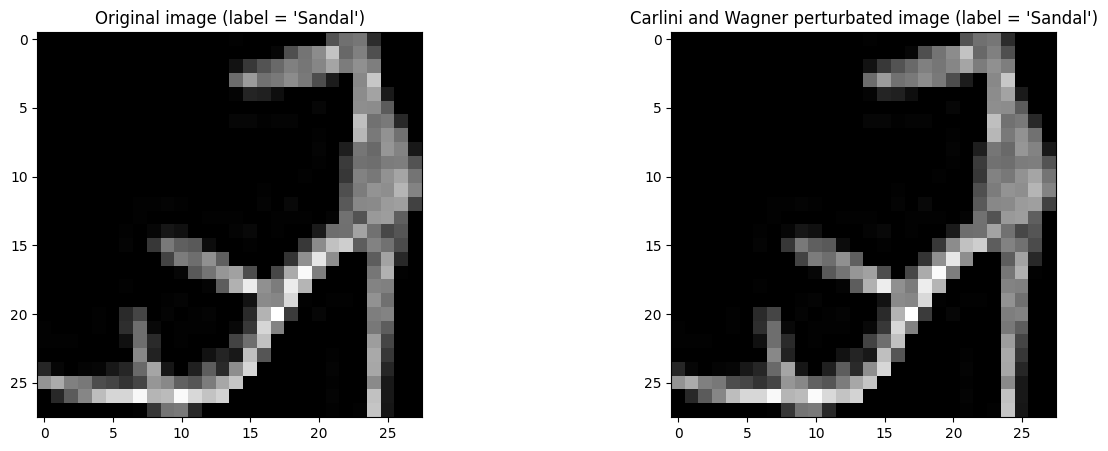

In [ ]:
i = np.random.choice(range(n_samples))
x = all_xs[i]
true_label = true_labels[i]
test_key, epsilons = sample_gaussian(test_key, (1, model.n_classes * K, model.d_latent))
epsilon = epsilons[0]

corruption_model = untargeted_WG_Attack(model, max_iter=100, learning_rate=0.0001, c = 0.1, p=2)
corrupted_x, new_label, perturbation_norm = corruption_model.get_perturbation(x, epsilon, all_ys, K)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(x.reshape(28, 28), cmap="gray")
axs[0].set_title(f"Original image (label = '{map_label_to_name(true_label)}')")

axs[1].imshow(corrupted_x.reshape(28, 28), cmap="gray")
axs[1].set_title(f"Carlini and Wagner perturbated image (label = '{map_label_to_name(new_label)}')")

plt.show()